# **Portfolio Tracker: Implementation in a Multi-Asset Portfolio Allocation**

## **Preparation of the Working Environment on Python**

Below, we detail the essential Python packages that constitute the basis of our portfolio and run a script to check if the required packages for this project are well installed in the Python environment.

- Pandas for data manipulation.
- NumPy for mathematical operations and complex computations with data.
- SciPy in order to perform, for instance, the complex portfolio optimisation frameworks that we will implement in this project.
- Matplotlib, seaborn and ploty for data visualisation.
- Riskfolio-lib as an additional tool to help us compute portfolio strategies.

In [110]:
# #Install Riskfolio library for portfolio allocation and optimisation and ploty for data visualisation.
# !pip install riskfolio-lib
# !pip install plotly==5.19.0

We import the necessary libraries to perform the analysis.

In [111]:
#Install the preliminary packages to run the code
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **1. Data and Initial Backtest**

This portfolio is strategically diversified across **Bonds, Equities, Alternatives, and Gold** to balance **risk and return** while ensuring broad market exposure.

### **1. Bonds (Fixed Income)**
A defensive allocation to **government bonds, corporate bonds, and ultrashort bonds**, providing stability and income.

- **Vanguard U.K. Gilt UCITS ETF (GB)**: Exposure to **UK government bonds (Gilts)**, benefiting from interest rate declines.
- **Vanguard Total Bond Market Index**: A diversified bond ETF covering **investment-grade government and corporate bonds**.
- **iShares € High Yield Corporate Bond**: Provides access to **high-yield (non-investment-grade) corporate bonds**, offering **higher returns with increased risk**.
- **iShares £ Ultrashort Bond UCITS**: Focuses on **low-volatility, short-duration bonds**, ideal for capital preservation and liquidity.

---

### **2. Equities (Growth Assets)**
The equity portion drives **long-term capital appreciation**, covering **global, emerging market, and U.S. stocks**.

- **iShares MSCI World ETF**: A broad exposure to **developed market equities**, tracking the MSCI World Index.
- **iShares Core MSCI EM IMI UCITS**: Focused on **emerging markets**, offering exposure to high-growth economies such as **China, India, and Brazil**.
- **Vanguard S&P 500 UCITS ETF (USD)**: Invests in the **500 largest U.S. companies**, capturing **U.S. market performance and innovation-driven growth**.

---

### **3. Alternatives (Inflation-Protected & Infrastructure)**
Alternative investments enhance diversification and offer **inflation-resistant assets**.

- **iShares Global Infrastructure ETF**: Provides exposure to **global infrastructure projects**, including **transportation, utilities, and energy sectors**, known for **steady cash flows and inflation protection**.

---

### **4. Gold (Safe-Haven Asset)**
Gold serves as a **hedge against inflation, currency depreciation, and market downturns**.

- **SPDR Gold Shares (GLD)**: A physically-backed gold ETF, offering **direct exposure to gold prices**, acting as a **store of value in volatile markets**.

---

### **Portfolio Strategy**
- **Growth**: Equities drive long-term capital appreciation.
- **Stability**: Bonds ensure steady income and downside protection.
- **Inflation Protection**: Alternatives (Infrastructure) and Gold act as hedges.
- **Liquidity Management**: Ultrashort bonds and diversified exposure provide flexibility.

This **balanced allocation** enables **long-term wealth accumulation** while managing **risk efficiently**.

We start by importing the datasets from an Excel file (name: Data.xlsx). The structure of the Excel file is directly linked to Refinitiv Eikon to grab the necessary data for the analysis. For convenience, we deconstructed the investment universe into G10 rates (3-month deposit rates), FX rates (G10 FX pairs against the US dollar as the reference currency). For the US dollar, we take the USD index "Ticker: =USD" to serve as a proxy for US dollar and capture the behavior of US dollar against other major currencies. We also have an additional ETF sheet with the oil, gold and additional tracker selected (URTH.K). We display the data for which is structured into three main sheets. NB: Please ensure the Excel file is located in the right place for proper execution.

In [112]:
# Importing the datasets from Excel file
ETF_data = pd.read_excel('Data_pf.xlsx', sheet_name="data_pf")

In [113]:
# Rename the first column to 'Date' in both dataframes
ETF_data.rename(columns={ETF_data.columns[0]: 'Date'}, inplace=True)

# We convert the 'Date' columns to datetime
ETF_data['Date'] = pd.to_datetime(ETF_data['Date'])

# # First merge: Merge FX_data and Rates_data on 'Date'
# merged_df = pd.merge(FX_data, Rates_data, on='Date', how='outer')

# # Second merge: Merge the result with ETF_data on 'Date'
# merged_df = pd.merge(merged_df, ETF_data, on='Date', how='outer')

# Removing rows with any NA values
ETF_data.dropna(inplace=True)

# Ensuring all columns except 'Date' are numeric
numeric_cols = ETF_data.select_dtypes(include=[float, int]).columns
ETF_data[numeric_cols] = ETF_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# We set the 'Date' column as the index
ETF_data.set_index('Date', inplace=True)

In [114]:
# Compute arithmetic returns for all the inverted currency columns
arith_returns = ETF_data.pct_change().dropna()
arith_returns_modified= ETF_data.pct_change().dropna()

# Look at the first few rows of returns
print(arith_returns.head())
print(arith_returns.describe())
print(arith_returns_modified.describe())

            iShares MSCI World ETF  iShares Core MSCI EM IMI UCITS  \
Date                                                                 
2015-03-31               -0.014355                       -0.017828   
2015-04-30                0.017830                        0.076361   
2015-05-31                0.004279                       -0.036247   
2015-06-30               -0.038615                       -0.033990   
2015-07-31                0.026316                       -0.066209   

            Vanguard S&P 500 UCITS ETF USD  Vanguard U.K. Gilt UCITS ETF GB  \
Date                                                                          
2015-03-31                        0.023338                         0.019102   
2015-04-30                       -0.023839                        -0.022654   
2015-05-31                        0.010480                         0.001294   
2015-06-30                       -0.050999                        -0.020094   
2015-07-31                        0

This step serves to filter outliers and ensure that the dataset is reliable. We implement some boundary conditions on the returns and eliminated any extreme value (inf and NaNs cells) that would distort the accuracy and hinder the quality of the dataset. However, the inversion of FX rates distorted in some way the correlation structure.

In [115]:
inf_indices = arith_returns_modified.index[arith_returns.isin([np.inf, -np.inf]).any(axis=1)]
print("Rows with Infinite Values:", inf_indices)

# We convert infinite values to NaN so they can be handled uniformly.
arith_returns.replace([np.inf, -np.inf], np.nan, inplace=True)

# We cap the return values in order to prevent for extremely high or low returns that may indicate data errors
outlier_threshold = 0.2
outliers = arith_returns_modified[(arith_returns_modified.abs() > outlier_threshold).any(axis=1)]
print("Potential Outliers:", outliers)

Rows with Infinite Values: DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)
Potential Outliers:             iShares MSCI World ETF  iShares Core MSCI EM IMI UCITS  \
Date                                                                 
2020-03-31               -0.130925                       -0.143894   

            Vanguard S&P 500 UCITS ETF USD  Vanguard U.K. Gilt UCITS ETF GB  \
Date                                                                          
2020-03-31                       -0.073534                         0.029738   

            Vanguard Total Bond Market Index  iShares € High Yield Corp Bond  \
Date                                                                           
2020-03-31                         -0.016252                       -0.142203   

            iShares £ Ultrashort Bond UCITS  SPDR Gold Shares  \
Date                                                            
2020-03-31                        -0.014079         -0.002224   

 

In [116]:
arith_returns.replace([np.inf, -np.inf], np.nan, inplace=True)
arith_returns.fillna(method='ffill', inplace=True)  # Forward fill again if new NaNs are introduced
arith_returns.dropna(inplace=True)
cap_threshold = 0.05  # 5% cap
arith_returns_scaled = arith_returns_modified.clip(lower=-cap_threshold, upper=cap_threshold)

print(arith_returns_scaled.describe())

       iShares MSCI World ETF  iShares Core MSCI EM IMI UCITS  \
count              120.000000                      120.000000   
mean                 0.007004                        0.002499   
std                  0.032377                        0.034863   
min                 -0.050000                       -0.050000   
25%                 -0.020318                       -0.027682   
50%                  0.011825                        0.005335   
75%                  0.031937                        0.031498   
max                  0.050000                        0.050000   

       Vanguard S&P 500 UCITS ETF USD  Vanguard U.K. Gilt UCITS ETF GB  \
count                      120.000000                       120.000000   
mean                         0.009770                        -0.001383   
std                          0.031110                         0.023817   
min                         -0.050000                        -0.050000   
25%                         -0.013861       

/var/folders/6g/sj5xds7s6c74p18crlqk8mpm0000gn/T/ipykernel_1563/2626157249.py:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [117]:
annualized_mean_returns = ((1 + arith_returns_scaled).prod()) ** (12 / len(arith_returns_scaled)) - 1

# To annualize standard deviation (volatility), we multiply by the square root of the number of trading days (we took 252, but the results can be recomputed to 360 days convention if in daily time frame). We use a monthly time frame in the analysis, so we take 12 calendar months in a year
annualized_std_dev = arith_returns_scaled.std() * np.sqrt(12)

annualized_results = pd.DataFrame({
    'Annualized Mean Return': annualized_mean_returns,
    'Annualized Volatility': annualized_std_dev
})

annualized_results

,Annualized Mean Return,Annualized Volatility
iShares MSCI World ETF,0.080631,0.112156
iShares Core MSCI EM IMI UCITS,0.022992,0.120770
Vanguard S&P 500 UCITS ETF USD,0.117368,0.107767
Vanguard U.K. Gilt UCITS ETF GB,-0.019799,0.082505
Vanguard Total Bond Market Index,-0.011962,0.051286
iShares € High Yield Corp Bond,-0.003193,0.063125
iShares £ Ultrashort Bond UCITS,0.001209,0.016310
SPDR Gold Shares,0.055038,0.109346
iShares Global Infrastructure,0.037147,0.112076


In [118]:
# Calculate cumulative returns
cumulative_returns = (1 + arith_returns_scaled).cumprod()

# Plotting for all the assets in the investment universe
'''
# Plot Cumulative Return Performance for each asset class separately
for column in cumulative_returns.columns:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    cumulative_returns[column].plot(title=f"Cumulative Return of {column}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
'''

'\n# Plot Cumulative Return Performance for each asset class separately\nfor column in cumulative_returns.columns:\n    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed\n    cumulative_returns[column].plot(title=f"Cumulative Return of {column}")\n    plt.xlabel("Date")\n    plt.ylabel("Cumulative Return")\n    plt.grid(True)\n    plt.show()\n'

We can look at the correlation between the different assets that are part of our investment universe. This relationship is critical to understand how each asset behaves with respect to the other assets in a portfolio and help in constructing a portfolio that is not heavily concentrated.

-   **Diversification:** The concept of diversification seeks to enhance returns while minimizing risk by investing in a variety of assets that will react differently to the same event (s). The diversification effect is a term that relates to the link between portfolio correlations and diversification. When there is an imperfect correlation between assets (positive or negative), the diversification effect occurs.

-   **Risk management:** The correlation matrix can be used to assess the overall risk profile of the portfolio. A portfolio with predominantly strong positive correlations may be more susceptible to market downturns, while a portfolio with a mix of positive, negative, and weak correlations may exhibit more stability.

<Figure size 1600x1200 with 0 Axes>

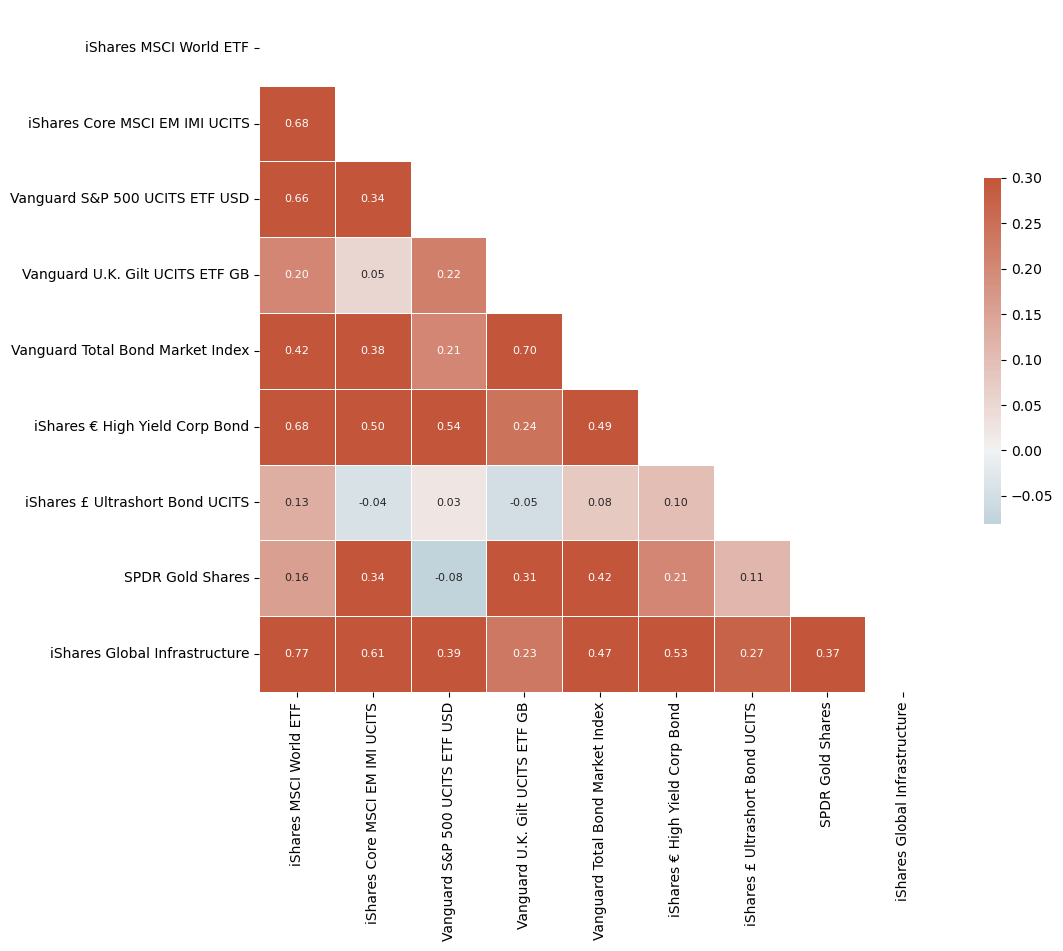

In [119]:
# Assuming 'data' is your DataFrame with each column being a time series of returns
correlation_matrix = arith_returns_scaled.corr()

# Using seaborn to create a heatmap of the correlation matrix
plt.figure(figsize=(16, 12))

# Generate a mask for the upper triangle.
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap.
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio.
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of the tick labels for clarity.
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [120]:
# Summary statistics
print(arith_returns_scaled.describe())
summary_stat_ret = arith_returns_scaled.describe()

""""
# Plotting all time series in the DataFrame
arith_returns.plot(figsize=(14, 7))
plt.title("Time series of asset returns")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()
"""

'''
# Box plot to visualize the distribution of returns
arith_returns_scaled.plot(kind='box', figsize=(10, 8))
plt.title("Box plot of asset returns")
plt.show()
'''

       iShares MSCI World ETF  iShares Core MSCI EM IMI UCITS  \
count              120.000000                      120.000000   
mean                 0.007004                        0.002499   
std                  0.032377                        0.034863   
min                 -0.050000                       -0.050000   
25%                 -0.020318                       -0.027682   
50%                  0.011825                        0.005335   
75%                  0.031937                        0.031498   
max                  0.050000                        0.050000   

       Vanguard S&P 500 UCITS ETF USD  Vanguard U.K. Gilt UCITS ETF GB  \
count                      120.000000                       120.000000   
mean                         0.009770                        -0.001383   
std                          0.031110                         0.023817   
min                         -0.050000                        -0.050000   
25%                         -0.013861       

'\n# Box plot to visualize the distribution of returns\narith_returns_scaled.plot(kind=\'box\', figsize=(10, 8))\nplt.title("Box plot of asset returns")\nplt.show()\n'

In [121]:
'''
for column in arith_returns_scaled.columns:
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    arith_returns_scaled[column].hist(bins=50, alpha=0.7)
    plt.title(f"Histogram of {column} Returns")
    plt.xlabel("Returns")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
'''

'\nfor column in arith_returns_scaled.columns:\n    plt.figure(figsize=(10, 6))  # Set the figure size for better readability\n    arith_returns_scaled[column].hist(bins=50, alpha=0.7)\n    plt.title(f"Histogram of {column} Returns")\n    plt.xlabel("Returns")\n    plt.ylabel("Frequency")\n    plt.grid(True)\n    plt.show()\n'

/var/folders/6g/sj5xds7s6c74p18crlqk8mpm0000gn/T/ipykernel_1563/1526165853.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



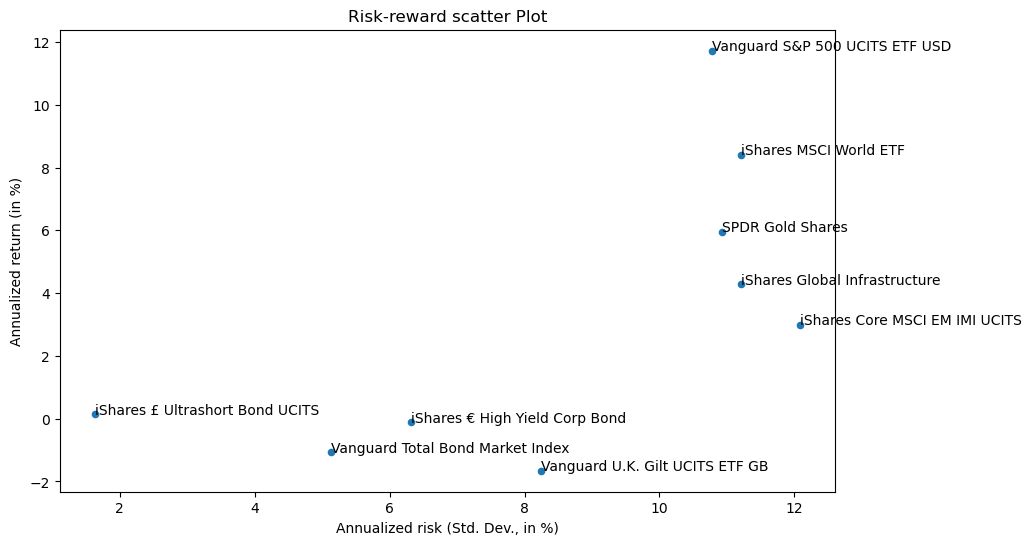

In [122]:
# Risk-Reward Scatter Plot
risk_reward = pd.DataFrame({
    'Return': arith_returns_scaled.mean() * 12 * 100,  # Annualize returns
    'Risk': arith_returns_scaled.std() * np.sqrt(12) * 100  # Annualize standard deviation
})
risk_reward.plot(kind='scatter', x='Risk', y='Return', figsize=(10, 6))
plt.title('Risk-reward scatter Plot')
plt.xlabel('Annualized risk (Std. Dev., in %)')
plt.ylabel('Annualized return (in %)')
for i, txt in enumerate(risk_reward.index):
    plt.annotate(txt, (risk_reward['Risk'][i], risk_reward['Return'][i]))

plt.show()

We aggregate our investment universe into different asset class groups to better capture the trends. We consolidated the asset retained in the investment universe into four different groups. The way of grouping assets would helps us to think of the portfolio allocation process in a more macro-oriented approach.

In [123]:
# Define assets by category
assets = {
    'Bonds': ["Vanguard U.K. Gilt UCITS ETF GB","Vanguard Total Bond Market Index","iShares € High Yield Corp Bond ","iShares £ Ultrashort Bond UCITS"],
    'Alternatives': ["iShares Global Infrastructure"],
    'Gold': ["SPDR Gold Shares"],
    'Equities' : ["iShares MSCI World ETF", "iShares Core MSCI EM IMI UCITS ", "Vanguard S&P 500 UCITS ETF USD "]
}
# Strip spaces from asset names in classification dictionary
assets = {k: [v.strip() for v in asset_list] for k, asset_list in assets.items()}


In [124]:
# Create a reverse mapping from asset to class
asset_to_class = {asset: cls for cls, asset_list in assets.items() for asset in asset_list}

# Initialize an empty DataFrame to store class returns
class_returns = pd.DataFrame(index=arith_returns_scaled.index)

# Calculate returns for each class
for cls in assets.keys():
    # Filter assets belonging to the current class
    class_assets = [asset for asset in assets[cls] if asset in arith_returns_scaled.columns]

    # Calculate the mean return for the class
    class_returns[cls] = arith_returns_scaled[class_assets].mean(axis=1)

# Now 'class_returns' contains the average returns for each asset class


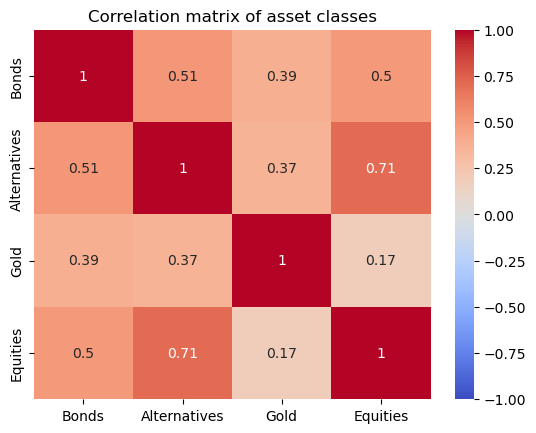

In [125]:
# Plot correlation matrix if more than one ticker in the category
asset_class_returns_corr = class_returns.dropna()
if len(asset_class_returns_corr) > 1:
    corr_matrix = asset_class_returns_corr.corr().round(3)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation matrix of asset classes")
    plt.show()

In [126]:
# Map each asset to its asset class
asset_classification = {}
for asset_class, asset_list in assets.items():
    for asset in asset_list:
        asset_classification[asset] = asset_class

# Check for missing assets
missing_assets = [asset for asset in arith_returns_scaled.columns if asset not in asset_classification]
if missing_assets:
    print("Warning: The following assets are missing from classification:", missing_assets)


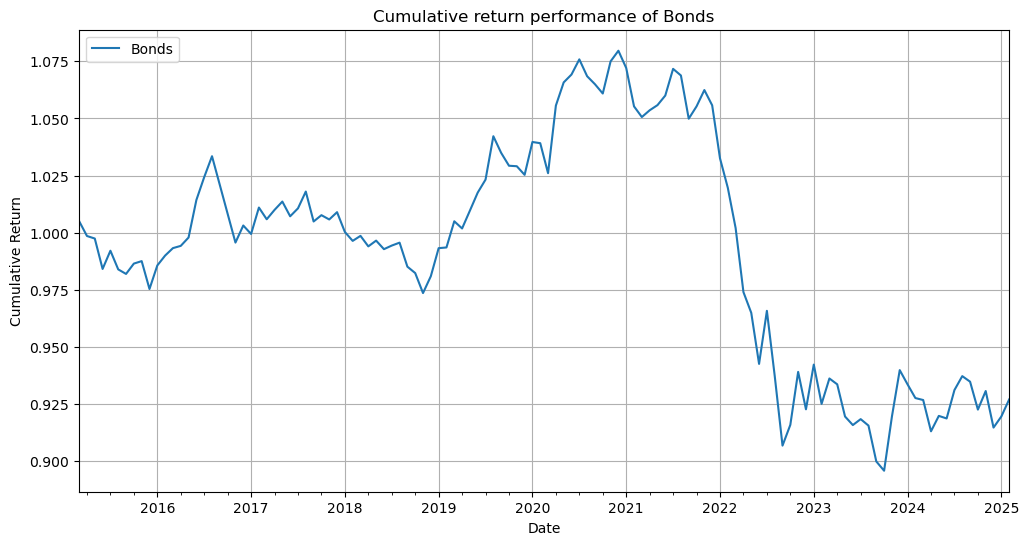

Statistical Data for Bonds:

       Mean (in %)  Standard Deviation (in %)  Skewness  Kurtosis
Bonds    -0.679809                   3.991147 -0.081453  0.306795

--------------------------------------------------



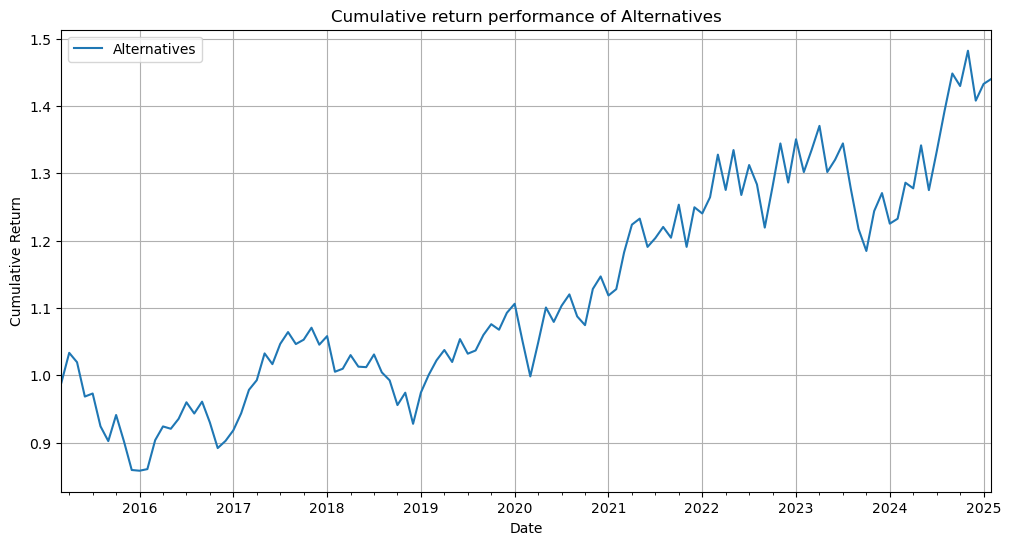

Statistical Data for Alternatives:

              Mean (in %)  Standard Deviation (in %)  Skewness  Kurtosis
Alternatives     4.277196                  11.207553 -0.241324 -1.119255

--------------------------------------------------



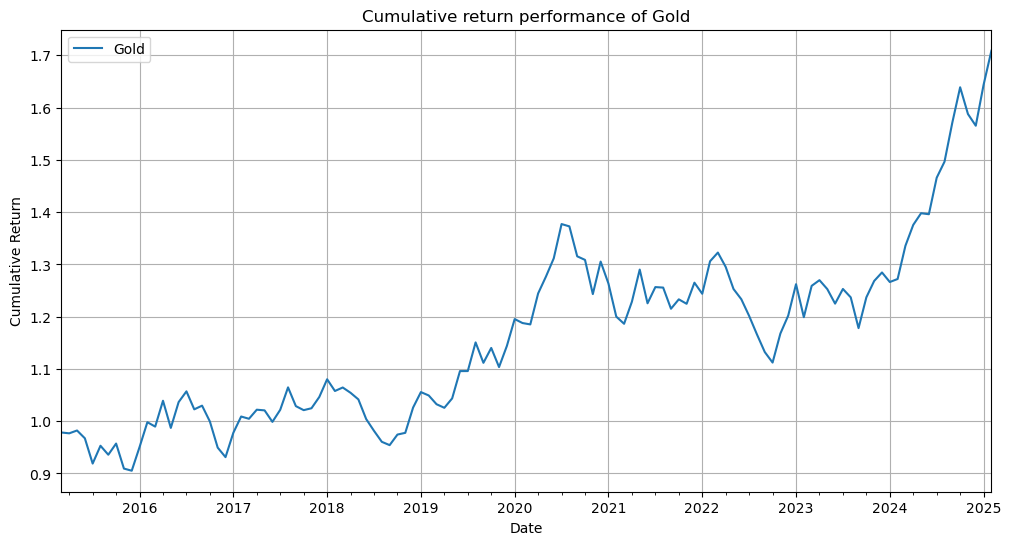

Statistical Data for Gold:

      Mean (in %)  Standard Deviation (in %)  Skewness  Kurtosis
Gold      5.96019                  10.934553 -0.017816 -1.150545

--------------------------------------------------



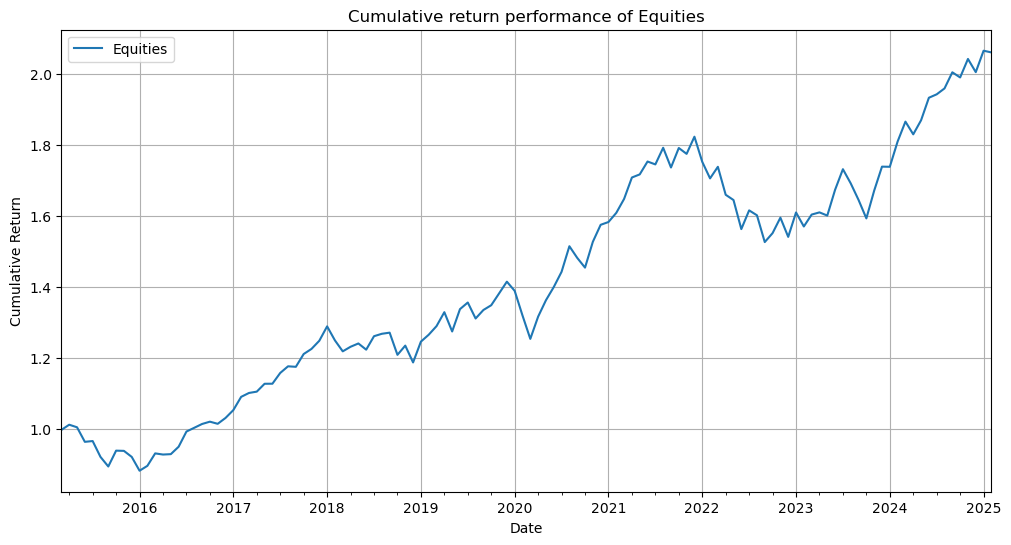

Statistical Data for Equities:

          Mean (in %)  Standard Deviation (in %)  Skewness  Kurtosis
Equities     7.709255                   9.537818 -0.421146 -0.750953

--------------------------------------------------



In [127]:
from scipy.stats import skew, kurtosis

for category in class_returns.columns:
    asset_class_returns = class_returns[[category]].dropna()
    cumulative_returns = (1 + asset_class_returns).cumprod()

    # Plot cumulative return performance

    cumulative_returns.plot(figsize=(12, 6), title=f"Cumulative return performance of {category}")
    plt.ylabel("Cumulative Return")
    plt.xlabel("Date")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

    # Calculate statistical metrics

    stats = pd.DataFrame({
        "Mean (in %)": asset_class_returns.mean()*12 * 100,
        "Standard Deviation (in %)": asset_class_returns.std()*np.sqrt(12) * 100,
        "Skewness": skew(asset_class_returns),
        "Kurtosis": kurtosis(asset_class_returns)
    })

    print(f"Statistical Data for {category}:\n")
    print(stats)
    print("\n" + "-" * 50 + "\n")


In [128]:
# Initialize a list to store stats for each asset class
all_stats = []

# Loop through each asset class and calculate stats
for category in class_returns.columns:
    asset_class_returns = class_returns[[category]].dropna()
    # Calculate statistical metrics
    category_stats = {
        "Category": category,
        "Mean (in %)": asset_class_returns.mean()[0] * 12 * 100,
        "Standard Deviation (in %)": asset_class_returns.std()[0] * np.sqrt(12) * 100,
        # "Sharpe Ratio" : asset_class_returns.mean()[0] * 12 * 100 / asset_class_returns.std()[0] * np.sqrt(12) * 100, #Risk-free rate is set at zero to as a simplification assumption
        "Skewness": skew(asset_class_returns)[0],
        "Kurtosis": kurtosis(asset_class_returns)[0]
    }
    # Append the dictionary to the list
    all_stats.append(category_stats)

# Create a DataFrame from the list of dictionaries
consolidated_stats_df = pd.DataFrame(all_stats)

# Set the index to the Category for readability
consolidated_stats_df.set_index('Category', inplace=True)

# Display the consolidated stats DataFrame
consolidated_stats_df

/var/folders/6g/sj5xds7s6c74p18crlqk8mpm0000gn/T/ipykernel_1563/2546715130.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/6g/sj5xds7s6c74p18crlqk8mpm0000gn/T/ipykernel_1563/2546715130.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/6g/sj5xds7s6c74p18crlqk8mpm0000gn/T/ipykernel_1563/2546715130.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/6g/sj5xds7s6c74p18crlqk8mpm0000gn/T/ipy

,Mean (in %),Standard Deviation (in %),Skewness,Kurtosis
Category,,,,
Bonds,-0.679809,3.991147,-0.081453,0.306795
Alternatives,4.277196,11.207553,-0.241324,-1.119255
Gold,5.960190,10.934553,-0.017816,-1.150545
Equities,7.709255,9.537818,-0.421146,-0.750953


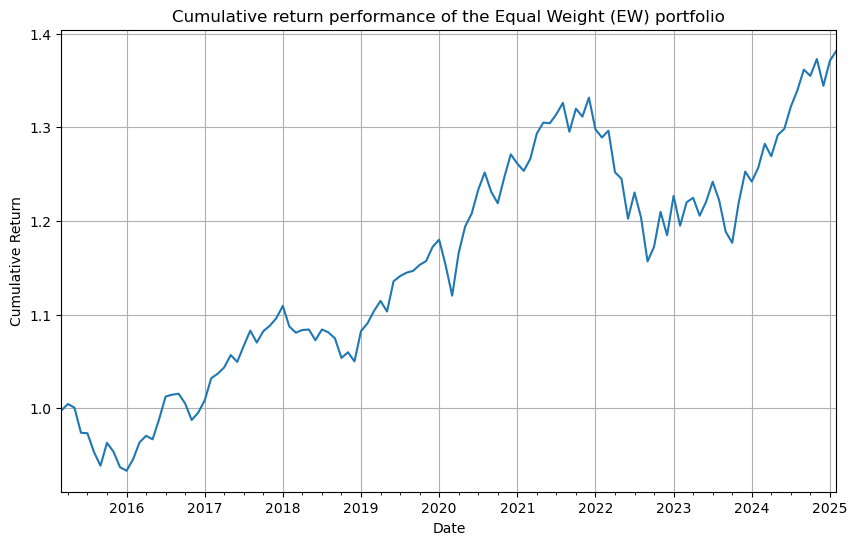

In [129]:
##Data and initial backtest

#Implementation of an equally weighted portfolio
# Calculate equal weights for each asset
num_assets = len(numeric_cols)
equal_weight = 1.0 / num_assets

# Calculate weighted returns for each asset
weighted_returns = arith_returns_scaled * equal_weight

# Calculate the monthly return of the equal weight portfolio
portfolio_monthly_return = weighted_returns.sum(axis=1)

# Calculate cumulative Returns for the portfolio
portfolio_cumulative_returns = (1 + portfolio_monthly_return).cumprod()

# Plot cumulative return performance of the portfolio
plt.figure(figsize=(10, 6))
portfolio_cumulative_returns.plot(title="Cumulative return performance of the Equal Weight (EW) portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

## **2. Implementation of Portfolio Strategies (Portfolio Strategies Signal)**

In this part of the project, we elaborate on the portfolio management techniques that were implemented.

In [130]:
import pandas as pd

# Adjust display options
pd.set_option('display.max_rows', None)  # No limit on the number of rows displayed
pd.set_option('display.max_columns', None)  # No limit on the number of columns displayed
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', 0)  # No limit on the column width

# Define the portfolio approaches and their utilities
data = {
    "Portfolio Approach": ["Mean-Variance (MV)", "Inverse Volatility", "Equal Risk Contribution (ERC)",
                           "Hierarchical Risk Parity (HRP)", "Maximum Sharpe Ratio (Maximum SR)", "Equal Weight", "Wall-Street Portfolio (WS)"],
    "Utility": [
        "Optimizes portfolio for the highest return per unit of risk, based on historical returns and volatilities.",
        "Allocates investment based on the inverse of the assets' volatilities, giving more weight to less volatile assets.",
        "Seeks to distribute risk equally among portfolio assets, aiming for each asset to contribute the same level of risk.",
        "Uses a hierarchical clustering algorithm to structure the portfolio into a hierarchy, optimizing for diversification and risk parity.",
        "Focuses on maximizing the Sharpe Ratio, selecting portfolio weights that offer the best expected return per unit of risk.",
        "Distributes capital evenly across all assets, ignoring market expectations, historical returns, or volatilities.",
        "Consensus of Wall-Street expectations on macroeconomic fundamentals for the different asset classes that covers our investment universe, based purely on a discretionary basis."
    ]
}

# Create the DataFrame
df_portfolio_approaches = pd.DataFrame(data).set_index('Portfolio Approach')

# Display the DataFrame
df_portfolio_approaches


,Utility
Portfolio Approach,
Mean-Variance (MV),"Optimizes portfolio for the highest return per unit of risk, based on historical returns and volatilities."
Inverse Volatility,"Allocates investment based on the inverse of the assets' volatilities, giving more weight to less volatile assets."
Equal Risk Contribution (ERC),"Seeks to distribute risk equally among portfolio assets, aiming for each asset to contribute the same level of risk."
Hierarchical Risk Parity (HRP),"Uses a hierarchical clustering algorithm to structure the portfolio into a hierarchy, optimizing for diversification and risk parity."
Maximum Sharpe Ratio (Maximum SR),"Focuses on maximizing the Sharpe Ratio, selecting portfolio weights that offer the best expected return per unit of risk."
Equal Weight,"Distributes capital evenly across all assets, ignoring market expectations, historical returns, or volatilities."
Wall-Street Portfolio (WS),"Consensus of Wall-Street expectations on macroeconomic fundamentals for the different asset classes that covers our investment universe, based purely on a discretionary basis."


### **Construction of portfolio strategies based on Riskfolio-lib package in Python**

We use the Riskfolio-lib package as an additional tool to check on the implemented strategies and compare overall results. We make an important use of it for the implementation of the Hierarchical Risk Parity (HRP) since its a technical procedure to implement and this package handles this type of portfolio allocation pretty easily and intuitively. Therefore, we will use the output given for the optimal portfolio computed on the full sample as the weights that will be used to compute the HRP returns.

In [131]:
#Using Riskfolio package

'''
https://github.com/dcajasn/Riskfolio-Lib/tree/master/examples
'''

import riskfolio as rp

#Fist strategy: Mean Variance portfolio construction

# Select method and estimate input parameters:
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

# Building the portfolio object
port = rp.Portfolio(returns=arith_returns_scaled)

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk-free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_MV = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

w_MV_df = pd.DataFrame(w_MV)

display(w_MV.T)

,iShares MSCI World ETF,iShares Core MSCI EM IMI UCITS,Vanguard S&P 500 UCITS ETF USD,Vanguard U.K. Gilt UCITS ETF GB,Vanguard Total Bond Market Index,iShares € High Yield Corp Bond,iShares £ Ultrashort Bond UCITS,SPDR Gold Shares,iShares Global Infrastructure
weights,8.318300e-10,2.176598e-10,0.644609,1.752394e-10,2.562041e-10,1.925352e-10,3.228886e-08,0.355391,2.796581e-10


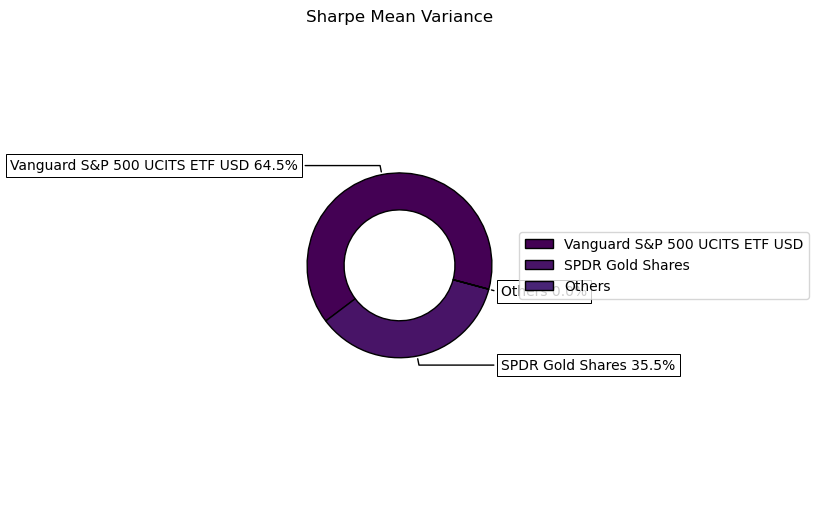

In [132]:
# Plotting the composition of the mean-variance portfolio

ax_sharpeMV = rp.plot_pie(w=w_MV, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "viridis",
                 height=5, width=8, ax=None)

In [133]:
#Second strategy: Estimation of the Risk Parity Portfolios (ERP)

b = None # Risk contribution constraints vector
w_ERC = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)
display(w_ERC.T)

w_ERC_df = pd.DataFrame(w_ERC)

'''
#Plotting the RP portfolio
ax_RiskParity_Variance = rp.plot_pie(w=w_ERC, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "viridis",
                 height=5, width=8, ax=None)
'''

,iShares MSCI World ETF,iShares Core MSCI EM IMI UCITS,Vanguard S&P 500 UCITS ETF USD,Vanguard U.K. Gilt UCITS ETF GB,Vanguard Total Bond Market Index,iShares € High Yield Corp Bond,iShares £ Ultrashort Bond UCITS,SPDR Gold Shares,iShares Global Infrastructure
weights,0.037703,0.043478,0.055071,0.076831,0.089468,0.072963,0.529242,0.058015,0.037231


'\n#Plotting the RP portfolio\nax_RiskParity_Variance = rp.plot_pie(w=w_ERC, title=\'Risk Parity Variance\', others=0.05, nrow=25, cmap = "viridis",\n                 height=5, width=8, ax=None)\n'

In [134]:
#Third strategy: Implementing Hierarchical Risk Parity (HRP) portfolio

# Building the portfolio object
port = rp.HCPortfolio(returns=arith_returns_scaled)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic
leaf_order = True # Consider optimal order of leafs in dendrogram

w_HRP = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

w_HRP_df = pd.DataFrame(w_HRP)
display(w_HRP.T)

,iShares MSCI World ETF,iShares Core MSCI EM IMI UCITS,Vanguard S&P 500 UCITS ETF USD,Vanguard U.K. Gilt UCITS ETF GB,Vanguard Total Bond Market Index,iShares € High Yield Corp Bond,iShares £ Ultrashort Bond UCITS,SPDR Gold Shares,iShares Global Infrastructure
weights,0.007028,0.006061,0.016942,0.028906,0.084053,0.025607,0.805361,0.017918,0.008124


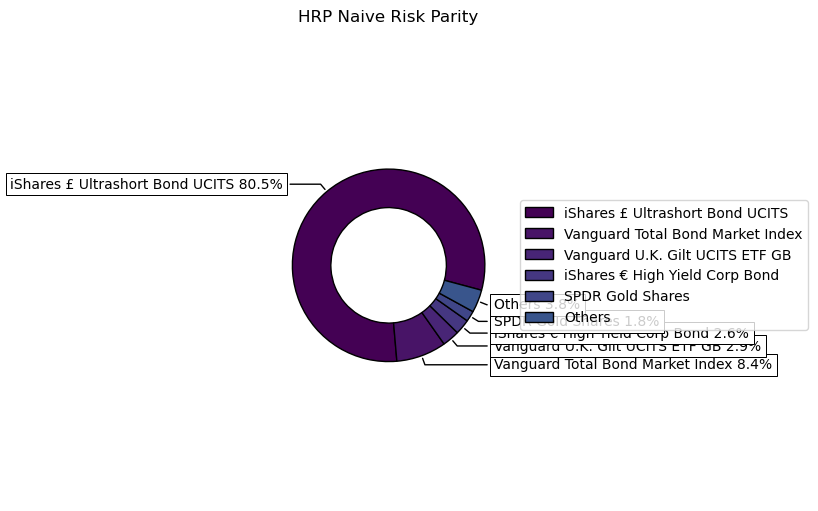

In [135]:
# Plotting the composition of the portfolio

ax_HRP_clustering_weights = rp.plot_pie(w=w_HRP,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="viridis",
                 height=5,
                 width=8,
                 ax=None)

### **Portfolio Strategies**

In [136]:
# For Equally Weighted (EW) portfolio
num_assets = len(arith_returns_scaled.columns)
equal_weights = 1 / num_assets
eq_weighted_returns = arith_returns_scaled * equal_weights
eq_portfolio_returns = eq_weighted_returns.sum(axis=1)

In [137]:
# Wall Street (WS) portfolio
class_weights = {"Bonds": 0.05,"Alternatives": 0.05, "Gold": 0.10, "Equities": 0.75}
asset_classification = {asset: asset_class for asset_class, asset_list in assets.items() for asset in asset_list}

# Allocate these weights to individual assets
ws_weights = {}
for asset in arith_returns_scaled.columns:
    asset_class = asset_classification[asset]
    class_asset_count = sum(1 for a in arith_returns_scaled.columns if asset_classification[a] == asset_class)
    ws_weights[asset] = class_weights[asset_class] / class_asset_count

#For the Wall Street portfolio
ws_weighted_returns = arith_returns_scaled.mul(pd.Series(ws_weights), axis=1)
ws_portfolio_returns = ws_weighted_returns.sum(axis=1)

We implement the classical Mean Variance (MV) portfolio in a Markowitz framework, and seek to compute the minimum variance portfolio which captures the portfolio with the lowest level of risk and is located in the lower tier of the efficient frontier.

In [138]:
from scipy.optimize import minimize

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_vol = portfolio_volatility(weights, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_vol

def optimize_portfolio(returns, method, risk_free_rate=0.0):
    # Ensure there are no negative or zero values in the returns to avoid unrealistic optimization results
    returns = returns.clip(lower=1e-4)

    # Calculate the covariance matrix
    cov_matrix = returns.cov()

    # Initial guess for the weights
    initial_guess = np.full(returns.shape[1], 1 / returns.shape[1])

    # Bounds for the weights
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    # Constraint: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # Optimization
    if method == 'MV':
        # Minimize volatility
        result = minimize(portfolio_volatility, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'IVol':
        # Maximize inverse volatility
        result = minimize(lambda w: -1 / portfolio_volatility(w, cov_matrix), initial_guess,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'ERC':
        # Equal risk contribution - minimize the difference in contribution to risk
        def risk_parity_objective(w, cov_matrix):
            marginal_risk = cov_matrix @ w
            total_risk = w @ marginal_risk
            risk_contributions = w * marginal_risk / total_risk
            return np.sum((risk_contributions - 1 / len(w)) ** 2)

        result = minimize(risk_parity_objective, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'Sharpe':
        # Maximize Sharpe ratio
        expected_returns = returns.mean() * 252
        result = minimize(negative_sharpe_ratio, initial_guess,
                          args=(expected_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)

    # Check if the optimization was successful
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)

    # Return the optimized weights
    return result.x

optimized_weights_mv = optimize_portfolio(arith_returns_scaled, 'MV')
optimized_weights_ivol = optimize_portfolio(arith_returns_scaled, 'IVol')
optimized_weights_erc = optimize_portfolio(arith_returns_scaled, 'ERC')
optimized_weights_sharpe = optimize_portfolio(arith_returns_scaled, 'Sharpe', risk_free_rate=0.00)

print(optimized_weights_mv)
print(optimized_weights_ivol)
print(optimized_weights_erc)
print(optimized_weights_sharpe)

[1.30381254e-17 0.00000000e+00 0.00000000e+00 1.03641116e-02
 5.55111512e-17 1.38967821e-17 9.89635888e-01 0.00000000e+00
 0.00000000e+00]
[0.00000000e+00 7.65159094e-08 3.65752144e-08 1.37261625e-02
 1.03461873e-09 1.49198886e-09 9.86273911e-01 0.00000000e+00
 0.00000000e+00]
[0.03915367 0.04486646 0.05241792 0.08512105 0.08784153 0.0673946
 0.53154401 0.04986356 0.0417972 ]
[0.01213214 0.05925617 0.12428336 0.09942204 0.         0.
 0.58812613 0.08304868 0.03373149]


In [139]:
assets = [
    "Vanguard U.K. Gilt UCITS ETF GB","Vanguard Total Bond Market Index","iShares € High Yield Corp Bond","iShares £ Ultrashort Bond UCITS",
    "iShares Global Infrastructure",
    "SPDR Gold Shares", "iShares MSCI World ETF", "iShares Core MSCI EM IMI UCITS", "Vanguard S&P 500 UCITS ETF USD"
]

# Optimized weights for each strategy, replace the ellipses with actual numbers
optimized_weights_mv = [
    1.30381254e-17, 0.00000000e+00, 0.00000000e+00, 1.03641116e-02,
 5.55111512e-17, 1.38967821e-17, 9.89635888e-01, 0.00000000e+00,
 0.00000000e+00
]
optimized_weights_ivol = [
    0.00000000e+00, 7.65159094e-08, 3.65752144e-08, 1.37261625e-02,
 1.03461873e-09, 1.49198886e-09, 9.86273911e-01, 0.00000000e+00,
 0.00000000e+00
]
optimized_weights_erc = [
    0.03915367, 0.04486646, 0.05241792, 0.08512105, 0.08784153, 0.0673946,
 0.53154401, 0.04986356, 0.0417972
]
optimized_weights_sharpe = [
    0.01213214, 0.05925617, 0.12428336, 0.09942204, 0.0, 0.0,
 0.58812613, 0.08304868, 0.03373149
]

# Now we consolidate the weights into dictionaries for each strategy
strategies = {
    'MV': dict(zip(assets, optimized_weights_mv)),
    'IVol': dict(zip(assets, optimized_weights_ivol)),
    'ERC': dict(zip(assets, optimized_weights_erc)),
    'Sharpe': dict(zip(assets, optimized_weights_sharpe))
}

# Create a DataFrame from the strategies_weights dictionary
strategies_df = pd.DataFrame(strategies)
print(strategies_df)

# Convert the strategies weights into individual dataframes for each strategy
mv_df = pd.DataFrame({'MV': optimized_weights_mv}, index=assets)
ivol_df = pd.DataFrame({'IVol': optimized_weights_ivol}, index=assets)
erc_df = pd.DataFrame({'ERC': optimized_weights_erc}, index=assets)
sharpe_df = pd.DataFrame({'Sharpe': optimized_weights_sharpe}, index=assets)

'''
mv_df, ivol_df, erc_df, sharpe_df
'''

                                            MV          IVol       ERC  \
Vanguard U.K. Gilt UCITS ETF GB   1.303813e-17  0.000000e+00  0.039154   
Vanguard Total Bond Market Index  0.000000e+00  7.651591e-08  0.044866   
iShares € High Yield Corp Bond    0.000000e+00  3.657521e-08  0.052418   
iShares £ Ultrashort Bond UCITS   1.036411e-02  1.372616e-02  0.085121   
iShares Global Infrastructure     5.551115e-17  1.034619e-09  0.087842   
SPDR Gold Shares                  1.389678e-17  1.491989e-09  0.067395   
iShares MSCI World ETF            9.896359e-01  9.862739e-01  0.531544   
iShares Core MSCI EM IMI UCITS    0.000000e+00  0.000000e+00  0.049864   
Vanguard S&P 500 UCITS ETF USD    0.000000e+00  0.000000e+00  0.041797   

                                    Sharpe  
Vanguard U.K. Gilt UCITS ETF GB   0.012132  
Vanguard Total Bond Market Index  0.059256  
iShares € High Yield Corp Bond    0.124283  
iShares £ Ultrashort Bond UCITS   0.099422  
iShares Global Infrastructure     

'\nmv_df, ivol_df, erc_df, sharpe_df\n'

Since implementing this strategy is challenging and required an advanced comprehension of the underlying model technique, we use the results obtained from the previous HRP computations performed using the riskfolio-lib package.

In [140]:
print(w_HRP)

                                   weights
iShares MSCI World ETF            0.007028
iShares Core MSCI EM IMI UCITS    0.006061
Vanguard S&P 500 UCITS ETF USD    0.016942
Vanguard U.K. Gilt UCITS ETF GB   0.028906
Vanguard Total Bond Market Index  0.084053
iShares € High Yield Corp Bond    0.025607
iShares £ Ultrashort Bond UCITS   0.805361
SPDR Gold Shares                  0.017918
iShares Global Infrastructure     0.008124


In [141]:
#Appliying Hierarchical Risk Parity

# Manually input the weights into a DataFrame
HRP_weights_data = {
"iShares MSCI World ETF":           0.007028,
"iShares Core MSCI EM IMI UCITS" :   0.006061,
"Vanguard S&P 500 UCITS ETF USD"  :  0.016942,
"Vanguard U.K. Gilt UCITS ETF GB"  : 0.028906,
"Vanguard Total Bond Market Index"  : 0.084053,
"iShares € High Yield Corp Bond"   : 0.025607,
"iShares £ Ultrashort Bond UCITS"   : 0.805361,
"SPDR Gold Shares"                  : 0.017918,
"iShares Global Infrastructure"     : 0.008124
}

# Creating a DataFrame from the HRP_weights_data dictionary
HRP_weights_df = pd.DataFrame([HRP_weights_data])

# Convert the weights dictionary into a DataFrame
HRP_weight_df = pd.DataFrame.from_dict(HRP_weights_data, orient='index', columns=['weights'])

# Transpose the weights dataframe to align with the returns dataframe
HRP_weights_df = HRP_weight_df.T

# Assuming 'arith_returns_scaled' is your DataFrame of asset returns
# Align the weights with the columns of the returns DataFrame

HRP_return_adapted = arith_returns_scaled
HRP_return_columns_adapted = arith_returns_scaled.columns
weights_aligned = HRP_weights_df.reindex(columns=HRP_return_adapted.columns).fillna(0)

# Compute the weighted returns
weighted_returns = arith_returns_scaled * weights_aligned.values

# Compute the monthly HRP portfolio returns
HRP_returns = weighted_returns.sum(axis=1)


In [142]:
#Compute monthly returns for each strategy

# Calculate monthly portfolio returns
MV_returns = arith_returns_scaled.mul(mv_df.squeeze(), axis=1).sum(axis=1)
IVol_returns = arith_returns_scaled.mul(ivol_df.squeeze(), axis=1).sum(axis=1)
ERC_returns = arith_returns_scaled.mul(erc_df.squeeze(), axis=1).sum(axis=1)
Sharpe_returns = arith_returns_scaled.mul(sharpe_df.squeeze(), axis=1).sum(axis=1)

EW_returns = (arith_returns_scaled * equal_weights).sum(axis=1)
WS_returns = (arith_returns_scaled * ws_weights).sum(axis=1)

# Concatenate them into a single DataFrame like this:
consolidated_portfolio_returns = pd.concat([
    MV_returns, IVol_returns, ERC_returns, EW_returns, Sharpe_returns, WS_returns, HRP_returns
], axis=1)
# Give appropriate column names corresponding to each strategy:
consolidated_portfolio_returns.columns = ['MV', 'Inv_vol', 'ERC','EW', 'SR', 'WS', 'HRP']

In [143]:
# For MV portfolio
MV_portfolio_mean_return = MV_returns.mean()* 12 * 100
MV_portfolio_volatility = MV_returns.std()* np.sqrt(12) * 100

# For ERC portfolio
ERC_portfolio_mean_return = ERC_returns.mean()* 12 * 100
ERC_portfolio_volatility = ERC_returns.std()* np.sqrt(12) * 100

# For Inverse of Volatility (Ivol) Portfolio
IVol_portfolio_mean_return = IVol_returns.mean()* 12 * 100
IVol_portfolio_volatility = IVol_returns.std()* np.sqrt(12) * 100


# For Hierarchical Risk Parity (HRP) Portfolio
HRP_portfolio_mean_return = HRP_returns.mean()* 12 * 100
HRP_portfolio_volatility = HRP_returns.std()* np.sqrt(12) * 100


# For Equally Weighted Portfolio
EW_portfolio_mean_return = eq_portfolio_returns.mean()* 12 * 100
EW_portfolio_volatility = eq_portfolio_returns.std()* np.sqrt(12) * 100

# For Wall Street Portfolio
WS_portfolio_mean_return = ws_portfolio_returns.mean()* 12 * 100
WS_portfolio_volatility = ws_portfolio_returns.std()* np.sqrt(12) * 100

In [144]:
portfolios = {
    "MV": MV_returns,
    "ERC": ERC_returns,
    "IVol": IVol_returns,
    "HRP": HRP_returns,
    "EW": eq_portfolio_returns,
    "WS": ws_portfolio_returns
}

# Create an empty dictionary to store performance metrics
portfolio_performance_metrics = {
    "Strategy": [],
    "Annualized Return (%)": [],
    "Annualized Volatility (%)": []
}

# Calculate the annualized return and volatility for each portfolio
for portfolio_name, returns in portfolios.items():
    portfolio_performance_metrics["Strategy"].append(portfolio_name)
    portfolio_performance_metrics["Annualized Return (%)"].append(returns.mean() * 12 *100)
    portfolio_performance_metrics["Annualized Volatility (%)"].append(returns.std() * np.sqrt(12) * 100)

# Create a DataFrame from the performance metrics dictionary
portfolio_performance_df = pd.DataFrame(portfolio_performance_metrics)

# Now 'portfolio_performance_df' is a DataFrame with the performance metrics for each portfolio
portfolio_performance_df

,Strategy,Annualized Return (%),Annualized Volatility (%)
0,MV,8.319029,11.101559
1,ERC,5.776420,8.101550
2,IVol,8.291224,11.064579
3,HRP,0.384221,1.734803
4,EW,3.405102,5.818989
5,WS,6.557829,7.953533


<Axes: title={'center': 'Cumulative Return of strategies'}, xlabel='Date'>

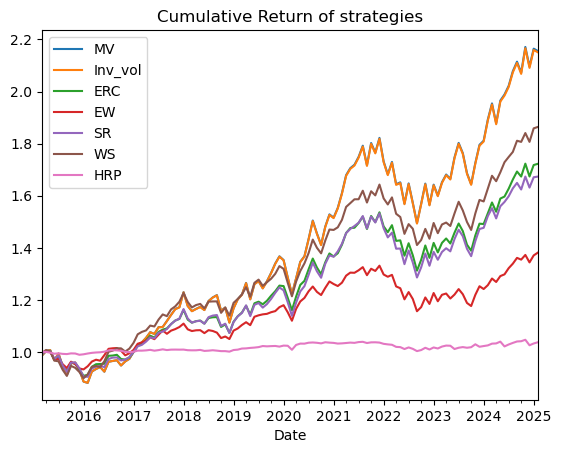

In [145]:
#Calculate cumulative returns

cumulative_returns = (1 + consolidated_portfolio_returns).cumprod()
cumulative_returns.plot(title="Cumulative Return of strategies")

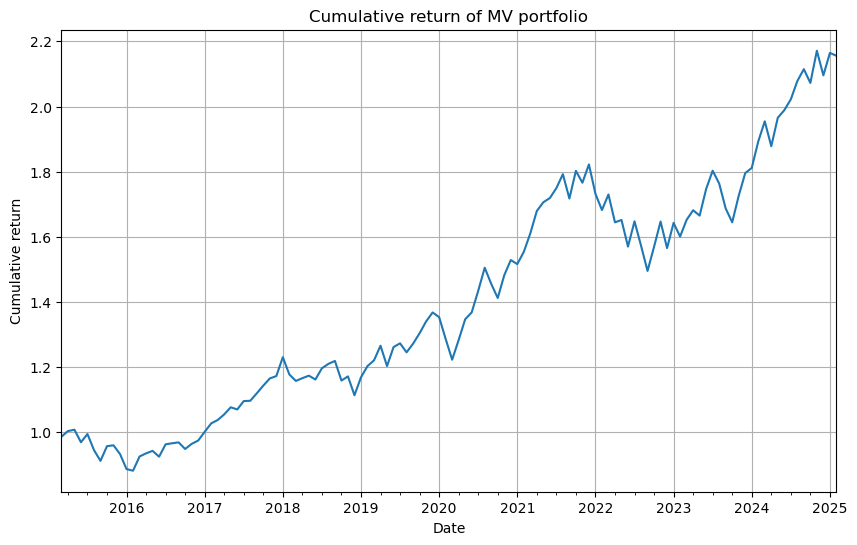

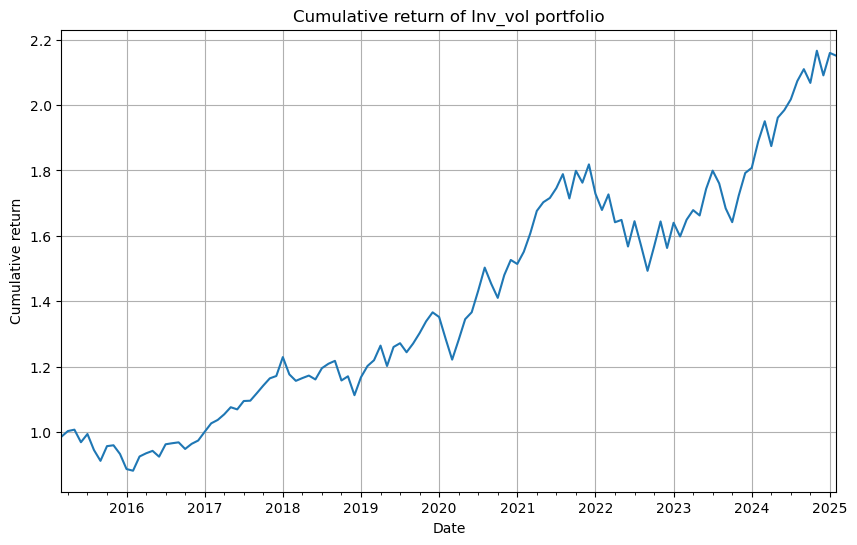

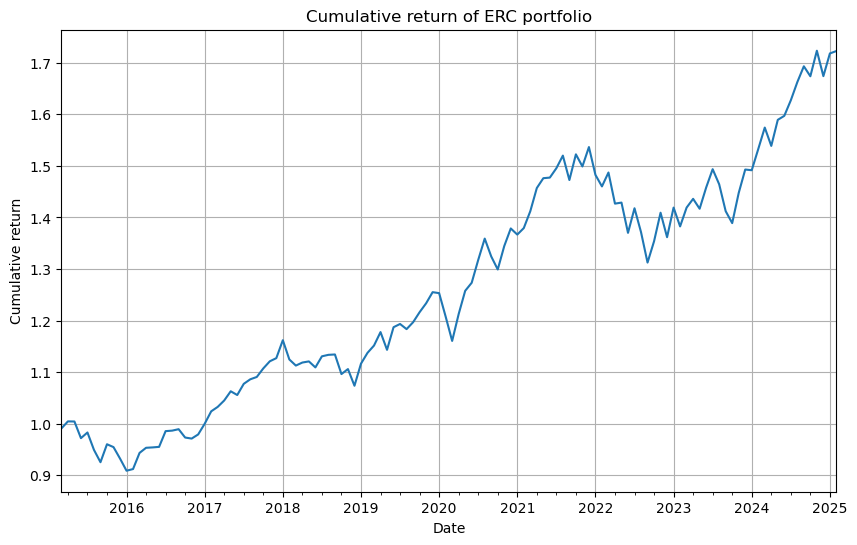

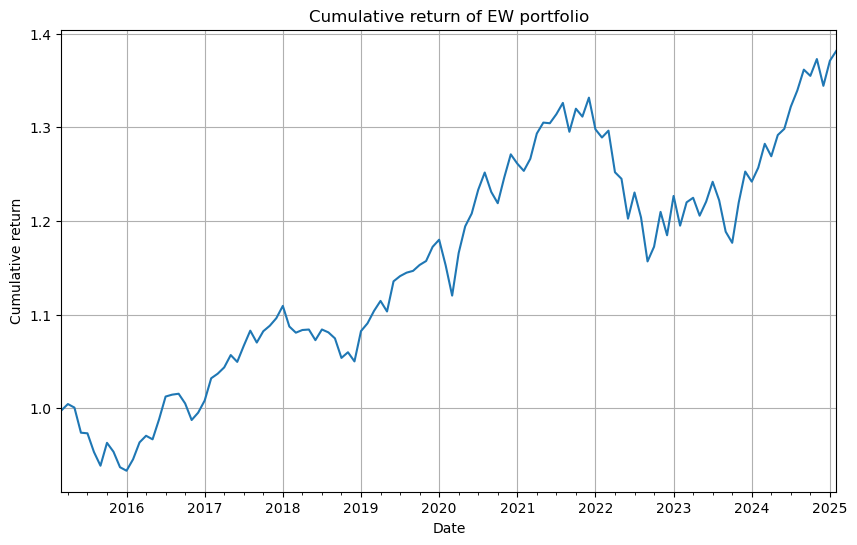

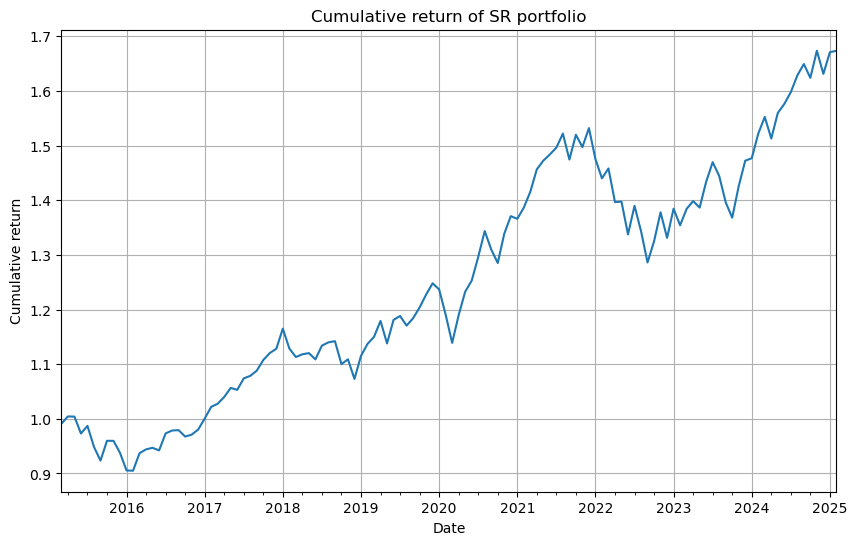

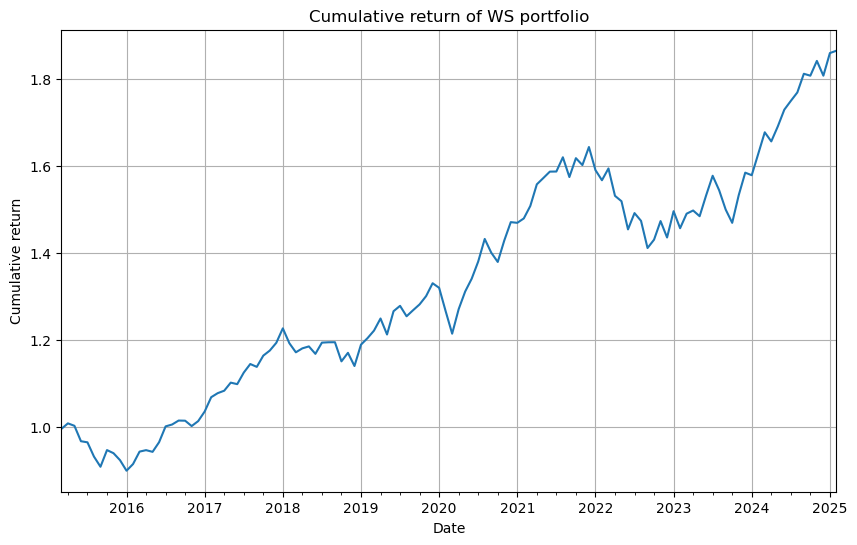

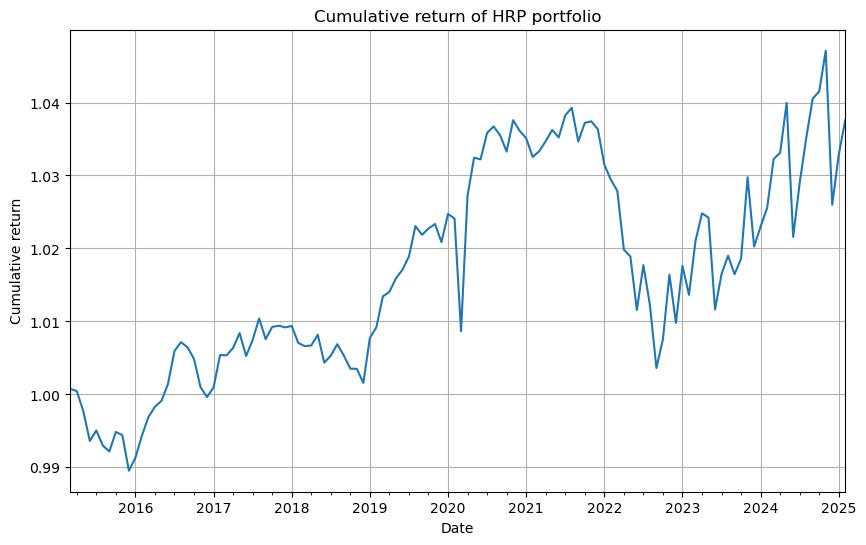

In [146]:
# Assuming 'consolidated_portfolio_returns' contains the monthly returns of each strategy
strategies = ['MV','Inv_vol','ERC', 'EW', 'SR', 'WS', 'HRP']  # List of all strategies

# Loop through each strategy to calculate and plot cumulative returns
for strategy in strategies:
    # Calculate cumulative returns
    cumulative_returns = (1 + consolidated_portfolio_returns[strategy]).cumprod()

    # Plot cumulative returns
    plt.figure(figsize=(10, 6))
    cumulative_returns.plot(title=f"Cumulative return of {strategy} portfolio")
    plt.xlabel("Date")
    plt.ylabel("Cumulative return")
    plt.grid(True)
    plt.show()

## **3. Basic Portfolio Analysis**

In [147]:
# Define the function to calculate performance metrics
def calculate_performance_metrics(portfolio_returns, risk_free_rate=0):
    # Annualize the risk-free rate (assuming it's provided on an annual basis)
    risk_free_rate_monthly = (1 + risk_free_rate) ** (1/12) - 1

    # Initialize a dictionary to store the results
    metrics = {
        "Total performance": [],
        "Annualized return": [],
        "Annualized volatility": [],
        "Annualized Sharpe Ratio": [],
    }

    # Loop over each strategy and calculate performance metrics
    for strategy in portfolio_returns.columns:
        # Total performance (cumulative return)
        cumulative_return = (1 + portfolio_returns[strategy]).cumprod()[-1]
        metrics["Total performance"].append(cumulative_return - 1)

        # Average monthly return
        annualized_return = portfolio_returns[strategy].mean() * (12)
        metrics["Annualized return"].append(annualized_return)

        # Annualized volatility
        annualized_volatility = portfolio_returns[strategy].std() * (12 ** 0.5)
        metrics["Annualized volatility"].append(annualized_volatility)

        # Annualized Sharpe Ratio
        sharpe_ratio = (annualized_return - risk_free_rate_monthly) / annualized_volatility
        metrics["Annualized Sharpe Ratio"].append(sharpe_ratio * (12 ** 0.5))


    # Convert metrics dictionary to DataFrame
    performance_metrics_df = pd.DataFrame(metrics, index=portfolio_returns.columns)

    # Format the DataFrame for better readability
    performance_metrics_df["Total performance"] = performance_metrics_df["Total performance"].map('{:.2%}'.format)
    performance_metrics_df["Annualized return"] = performance_metrics_df["Annualized return"].map('{:.2%}'.format)
    performance_metrics_df["Annualized volatility"] = performance_metrics_df["Annualized volatility"].map('{:.2%}'.format)
    performance_metrics_df["Annualized Sharpe Ratio"] = performance_metrics_df["Annualized Sharpe Ratio"].map('{:.2f}'.format)

    return performance_metrics_df

# Calculate the performance metrics
risk_free_rate_annual = 0.00
performance_metrics_df = calculate_performance_metrics(consolidated_portfolio_returns, risk_free_rate_annual)

# Display the performance metrics table
performance_metrics_df.reset_index().rename(columns={"index": "Strategy"})

/var/folders/6g/sj5xds7s6c74p18crlqk8mpm0000gn/T/ipykernel_1563/3924147129.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,Strategy,Total performance,Annualized return,Annualized volatility,Annualized Sharpe Ratio
0,MV,115.59%,8.32%,11.10%,2.60
1,Inv_vol,115.08%,8.29%,11.06%,2.60
2,ERC,72.26%,5.78%,8.10%,2.47
3,EW,38.17%,3.41%,5.82%,2.03
4,SR,67.36%,5.50%,8.29%,2.30
5,WS,86.41%,6.56%,7.95%,2.86
6,HRP,3.76%,0.38%,1.73%,0.77


## **4. Portfolio Strategies Risk Management**

For the portfolio risk management, we implemented a simple drawdown framework where we assess the assets selected in terms of their maximum loss, and seek for patterns related to their market behavior. We consolidate our risk framework in the part five of the project where we introduce VaR computation as a supplementary tool to make informed decision and compare strategies based on their risk.

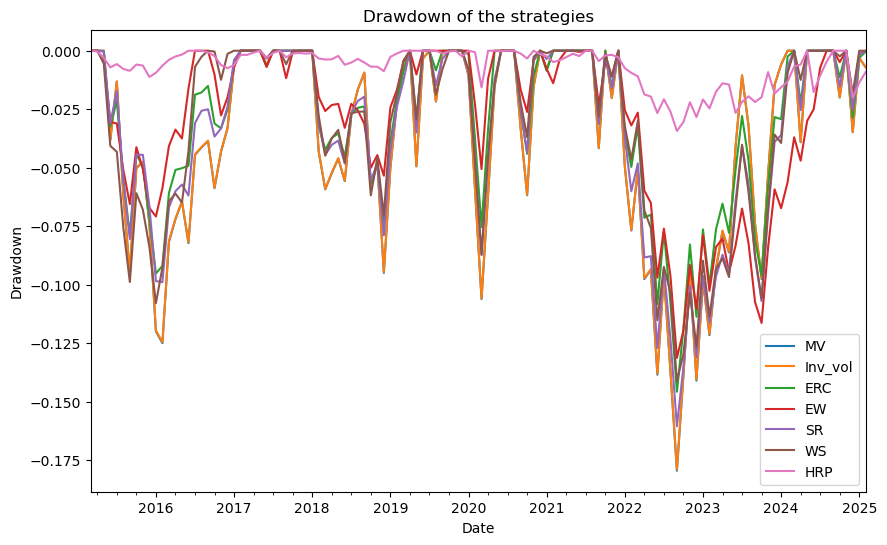

In [148]:
# Calculate the cumulative returns
cumulative_returns = (1 + consolidated_portfolio_returns).cumprod()

# Calculate the drawdown
drawdown = cumulative_returns.div(cumulative_returns.cummax()).subtract(1)

# Plot the drawdown
drawdown.plot(figsize=(10, 6))
plt.title('Drawdown of the strategies')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.show()

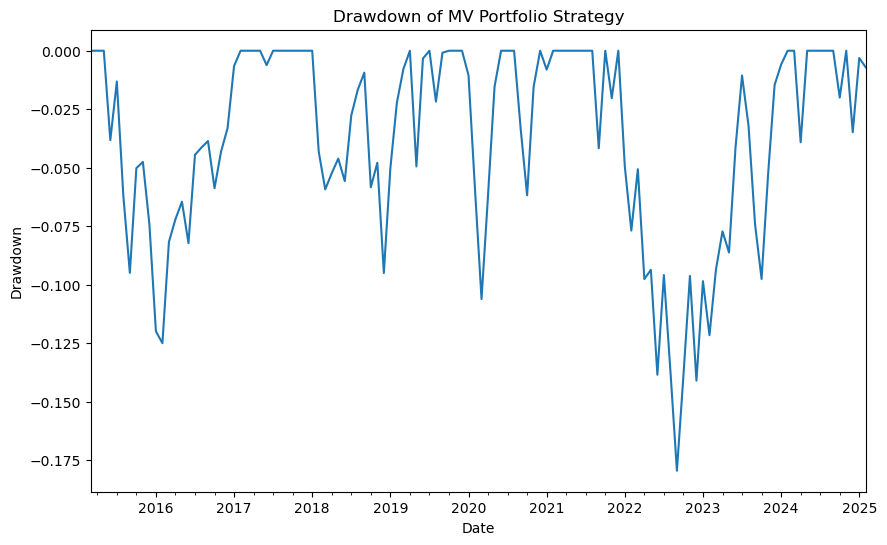

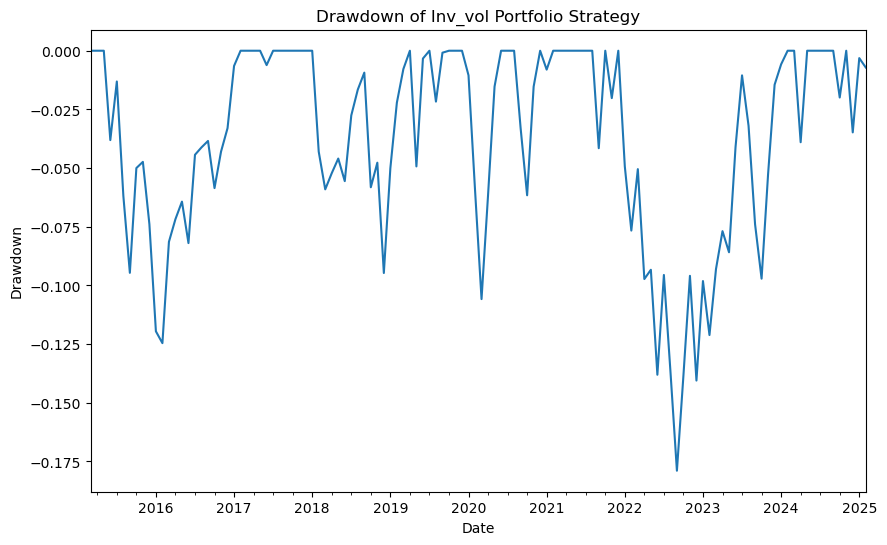

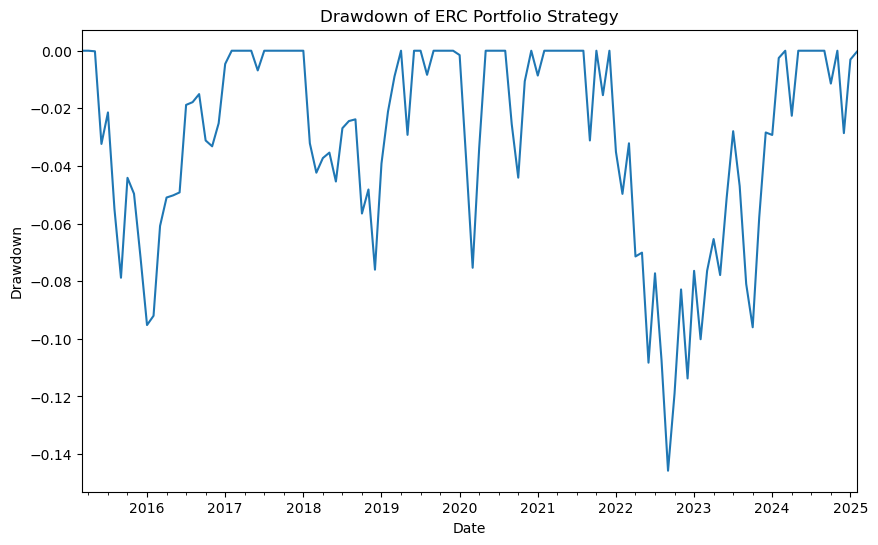

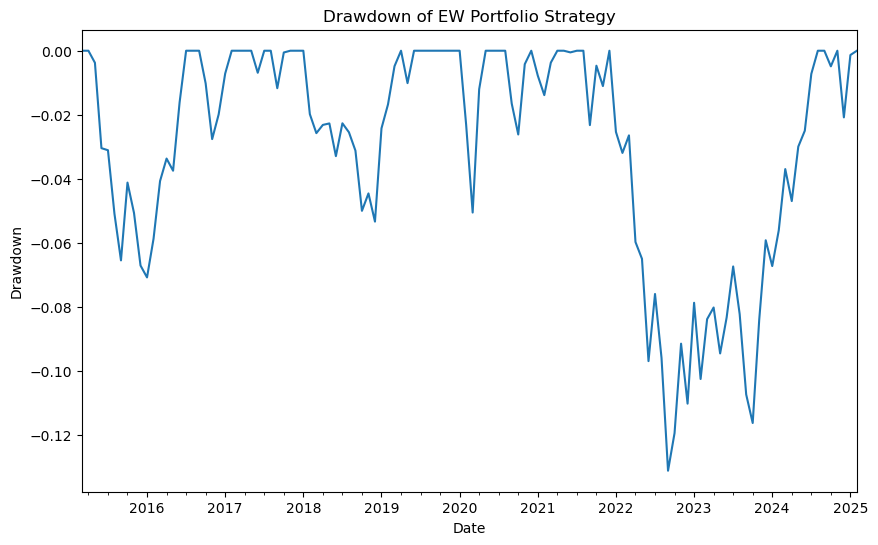

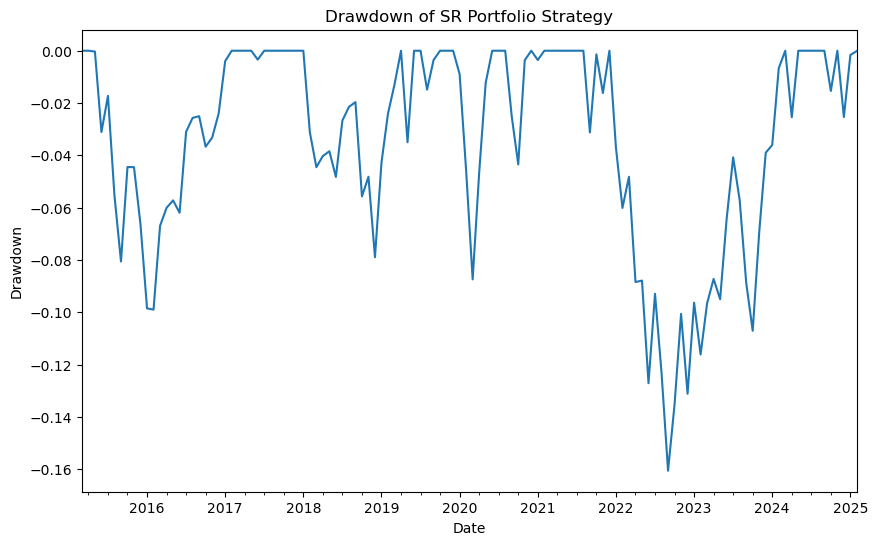

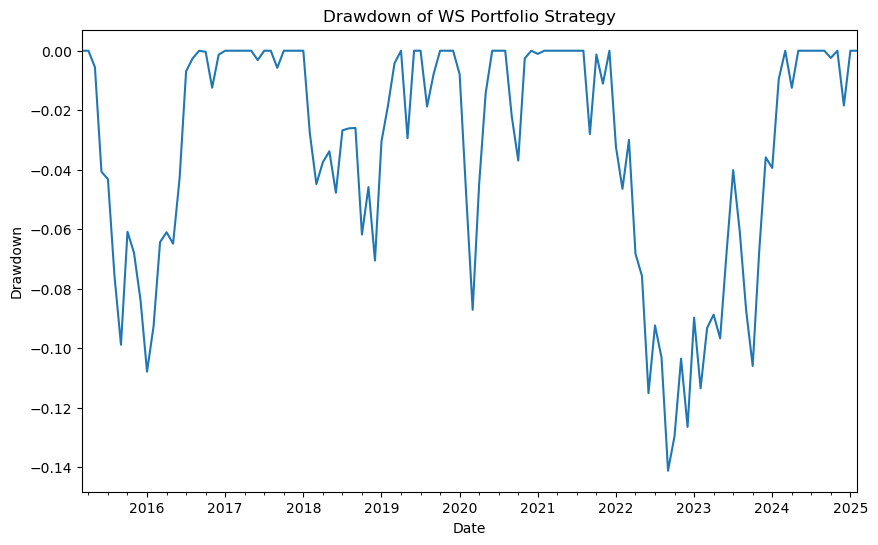

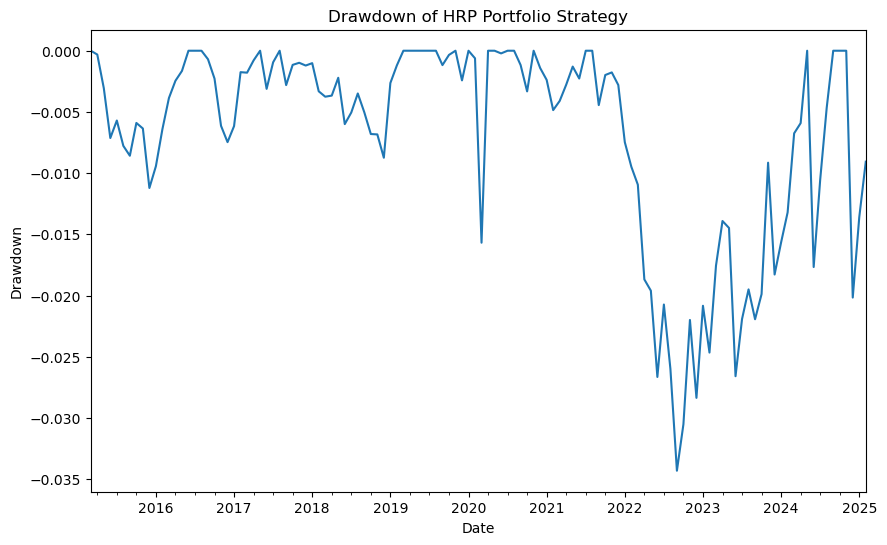

In [149]:
strategies = ['MV', 'Inv_vol', 'ERC', 'EW', 'SR', 'WS', 'HRP']  # List of all strategies

# Loop through each strategy to calculate and plot drawdown
for strategy in strategies:
    # Calculate the cumulative returns
    cumulative_returns = (1 + consolidated_portfolio_returns[strategy]).cumprod()

    # Calculate the drawdown
    drawdown = cumulative_returns.div(cumulative_returns.cummax()).subtract(1)

    # Plot the drawdown
    drawdown.plot(figsize=(10, 6))
    plt.title(f'Drawdown of {strategy} Portfolio Strategy')
    plt.ylabel('Drawdown')
    plt.xlabel('Date')
    plt.show()

/var/folders/6g/sj5xds7s6c74p18crlqk8mpm0000gn/T/ipykernel_1563/2153452895.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



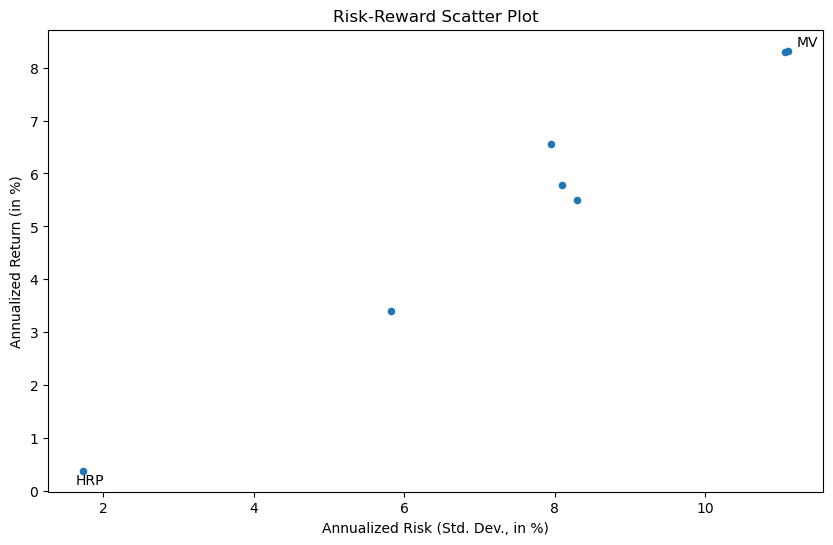

In [150]:

# Risk-Reward Scatter Plot
risk_reward_pf = pd.DataFrame({
    'Return': consolidated_portfolio_returns.mean() * 12 * 100,  # Annualize returns
    'Risk': consolidated_portfolio_returns.std() * np.sqrt(12) * 100  # Annualize standard deviation
})
risk_reward_pf.plot(kind='scatter', x='Risk', y='Return', figsize=(10, 6))
plt.title('Risk-Reward Scatter Plot')
plt.xlabel('Annualized Risk (Std. Dev., in %)')
plt.ylabel('Annualized Return (in %)')
for i, txt in enumerate(risk_reward_pf.index):
    plt.annotate(txt, (risk_reward['Risk'][i], risk_reward['Return'][i]))

plt.show()



import plotly.express as px

# Filter out strategies with extreme risk or return values
threshold_risk_upper = risk_reward_pf['Risk'].quantile(0.80)  # 95th percentile as upper threshold
threshold_risk_lower = risk_reward_pf['Risk'].quantile(0.05)  # 5th percentile as lower threshold

# Apply the thresholds to filter out the outliers
filtered_risk_reward_pf = risk_reward_pf[(risk_reward_pf['Risk'] < threshold_risk_upper) & (risk_reward_pf['Risk'] > threshold_risk_lower)]

# Plotting using Plotly for a dynamic plot
fig = px.scatter(filtered_risk_reward_pf, x='Risk', y='Return', text=filtered_risk_reward_pf.index)
fig.update_traces(textposition='top center')
fig.update_layout(
    title='Risk-Reward Scatter Plot',
    xaxis_title='Annualized Risk (Std. Dev., in %)',
    yaxis_title='Annualized Return (in %)',
    showlegend=False
)
fig.show()

<Figure size 1600x1200 with 0 Axes>

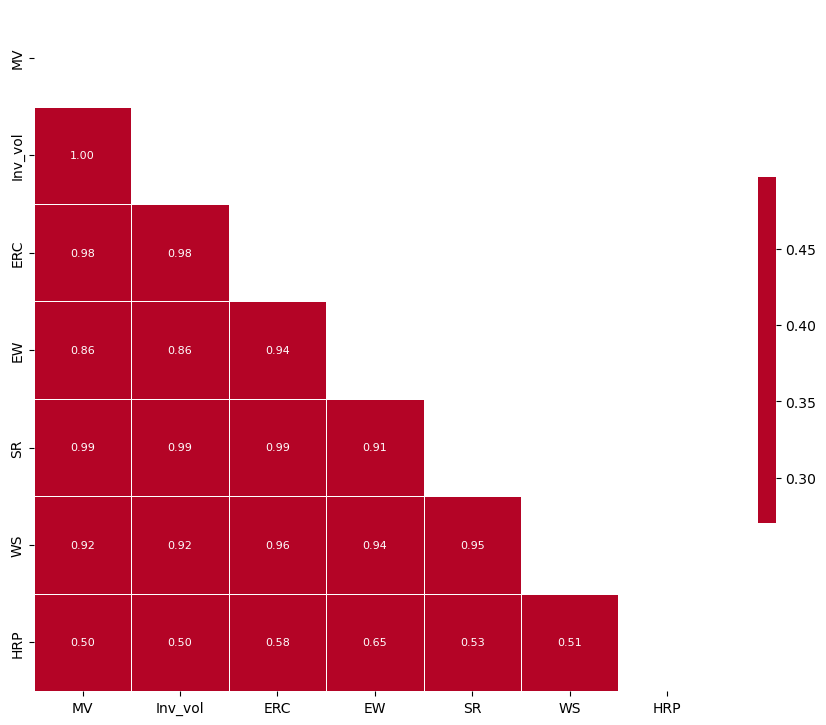

In [151]:
#Correlation of the portfolio strategies tested

correlation_matrix_pf = consolidated_portfolio_returns.corr()

# Using seaborn to create a heatmap of the correlation matrix
# Increase the size of the heatmap.
plt.figure(figsize=(16, 12))

# Generate a mask for the upper triangle.
mask = np.triu(np.ones_like(correlation_matrix_pf, dtype=bool))

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap.
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio.
sns.heatmap(correlation_matrix_pf, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of the tick labels for clarity.
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

##  **5. Advanced Portfolio analysis**

In [152]:
def calculate_performance_metrics(returns, risk_free_rate):
    # Annualize the risk-free rate (assuming it's provided on an annual basis)
    risk_free_rate_monthly = (1 + risk_free_rate) ** (1/12) - 1

    # Initialize a dictionary to store metrics
    metrics = {
        'Annualized Return (%)': returns.mean() * 12,
        'Annualized Volatility (%)': returns.std() * (12 ** 0.5),
        'Skewness': skew(returns),
        'Excess Kurtosis': kurtosis(returns) - 3,
        'Sortino Ratio': None,
        'VaR 95%': None,
        'CVaR 95%': None,
        'Max Drawdown (%)': None
    }

    # Calculate Sortino Ratio
    negative_returns = returns[returns < risk_free_rate_monthly]
    downside_std = np.sqrt(np.mean(negative_returns ** 2)) * (12 ** 0.5)
    metrics['Sortino Ratio'] = (metrics['Annualized Return (%)'] - risk_free_rate) / downside_std

    # Calculate VaR 95% and CVaR 95%
    metrics['VaR 95%'] = returns.quantile(0.05)
    metrics['CVaR 95%'] = returns[returns <= metrics['VaR 95%']].mean()

    # Calculate Max Drawdown
    cumulative_returns = (1 + returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / rolling_max - 1
    metrics['Max Drawdown (%)'] = drawdown.min()

    # Convert metrics to percentages where appropriate
    for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Max Drawdown (%)']:
        metrics[metric] = metrics[metric] * 100

    # Format the results for better readability
    formatted_metrics = {k: f"{v:.2f}" for k, v in metrics.items() if isinstance(v, float)}
    formatted_metrics['Skewness'] = f"{metrics['Skewness']:.3f}"
    formatted_metrics['Excess Kurtosis'] = f"{metrics['Excess Kurtosis']:.3f}"
    formatted_metrics['Sortino Ratio'] = f"{metrics['Sortino Ratio']:.3f}"
    formatted_metrics['VaR 95%'] = f"{metrics['VaR 95%']:.3f}"
    formatted_metrics['CVaR 95%'] = f"{metrics['CVaR 95%']:.3f}"

    return pd.Series(formatted_metrics)

# Calculate the performance metrics for each strategy
risk_free_rate_annual = 0.00
strategy_metrics_df = consolidated_portfolio_returns.apply(
    calculate_performance_metrics, risk_free_rate=risk_free_rate_annual)

# Display the formatted performance metrics
strategy_metrics_df.T

,Annualized Return (%),Annualized Volatility (%),Skewness,Excess Kurtosis,Sortino Ratio,VaR 95%,CVaR 95%,Max Drawdown (%)
MV,8.32,11.10,-0.402,-3.996,0.682,-0.049,-0.050,-17.95
Inv_vol,8.29,11.06,-0.402,-3.996,0.682,-0.049,-0.049,-17.90
ERC,5.78,8.10,-0.349,-3.908,0.660,-0.035,-0.039,-14.58
EW,3.41,5.82,-0.251,-3.478,0.574,-0.026,-0.032,-13.13
SR,5.50,8.29,-0.383,-3.852,0.601,-0.037,-0.041,-16.05
WS,6.56,7.95,-0.335,-3.819,0.827,-0.035,-0.040,-14.13
HRP,0.38,1.73,-0.858,1.236,0.195,-0.008,-0.014,-3.43


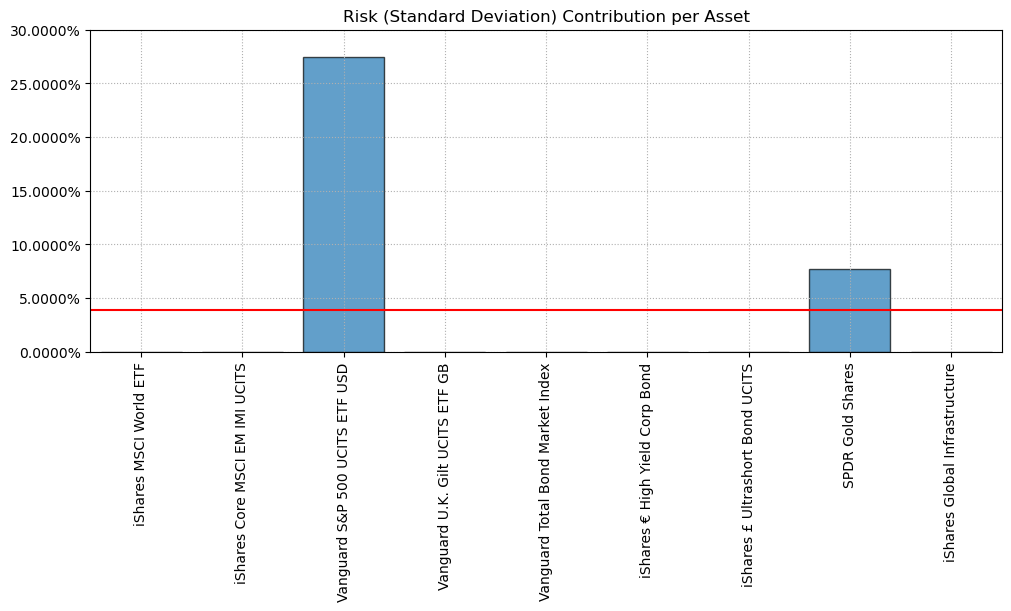

In [153]:
# Plotting the risk composition of the Minimum Variance (MV) portfolio

ax_sharpeMV_risk = rp.plot_risk_con(w_MV, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

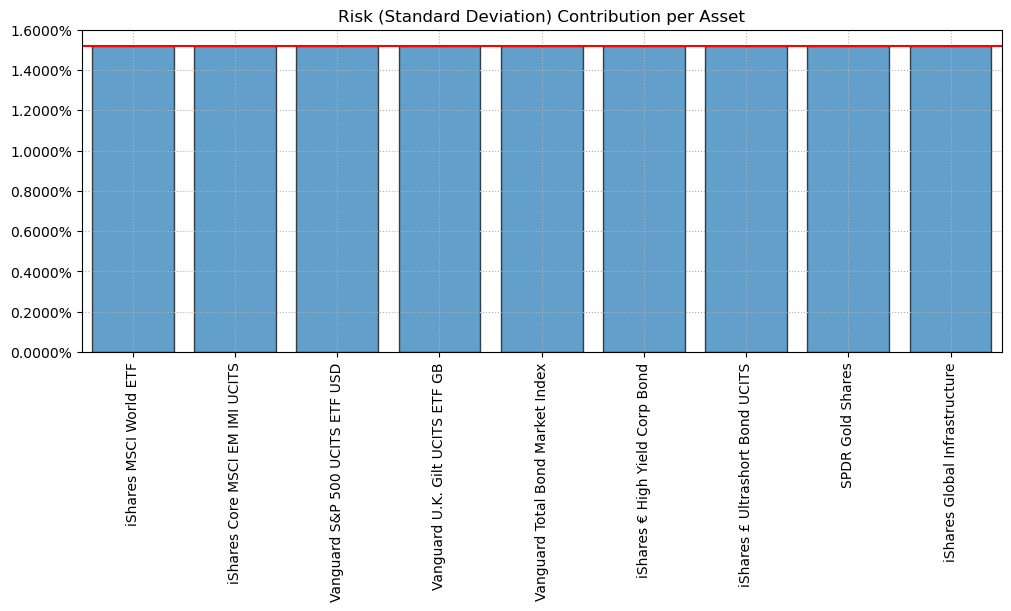

In [154]:
#Risk contribution of Risk Parity (ERC) portfolio
ax_RiskParity_Variance_risk= rp.plot_risk_con(w_ERC, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

In the context of the HRP, assets are grouped hierarchically using statistical methods, which typically entails measuring the distances between historical asset returns. 

It is possible to achieve diversification by looking at the groups and figuring out which assets can be put together. To spread risk, the portfolio should have at least one item from each group. A group of assets with a positive relative correlation is shown by the bright block on the graph. In other words, they are likely to move in the same way if the market stays the same. To get better risk-adjusted returns, it is important to balance these groups with assets from other groups that don't have strong ties. The HRP doesn't just put the assets into groups; it also gives them weights that are the opposite of how risky they are. Its purpose is to make sure that each group shares the portfolio's risk evenly. Some assets show low correlation. These assets can help lower the risk of a portfolio. 

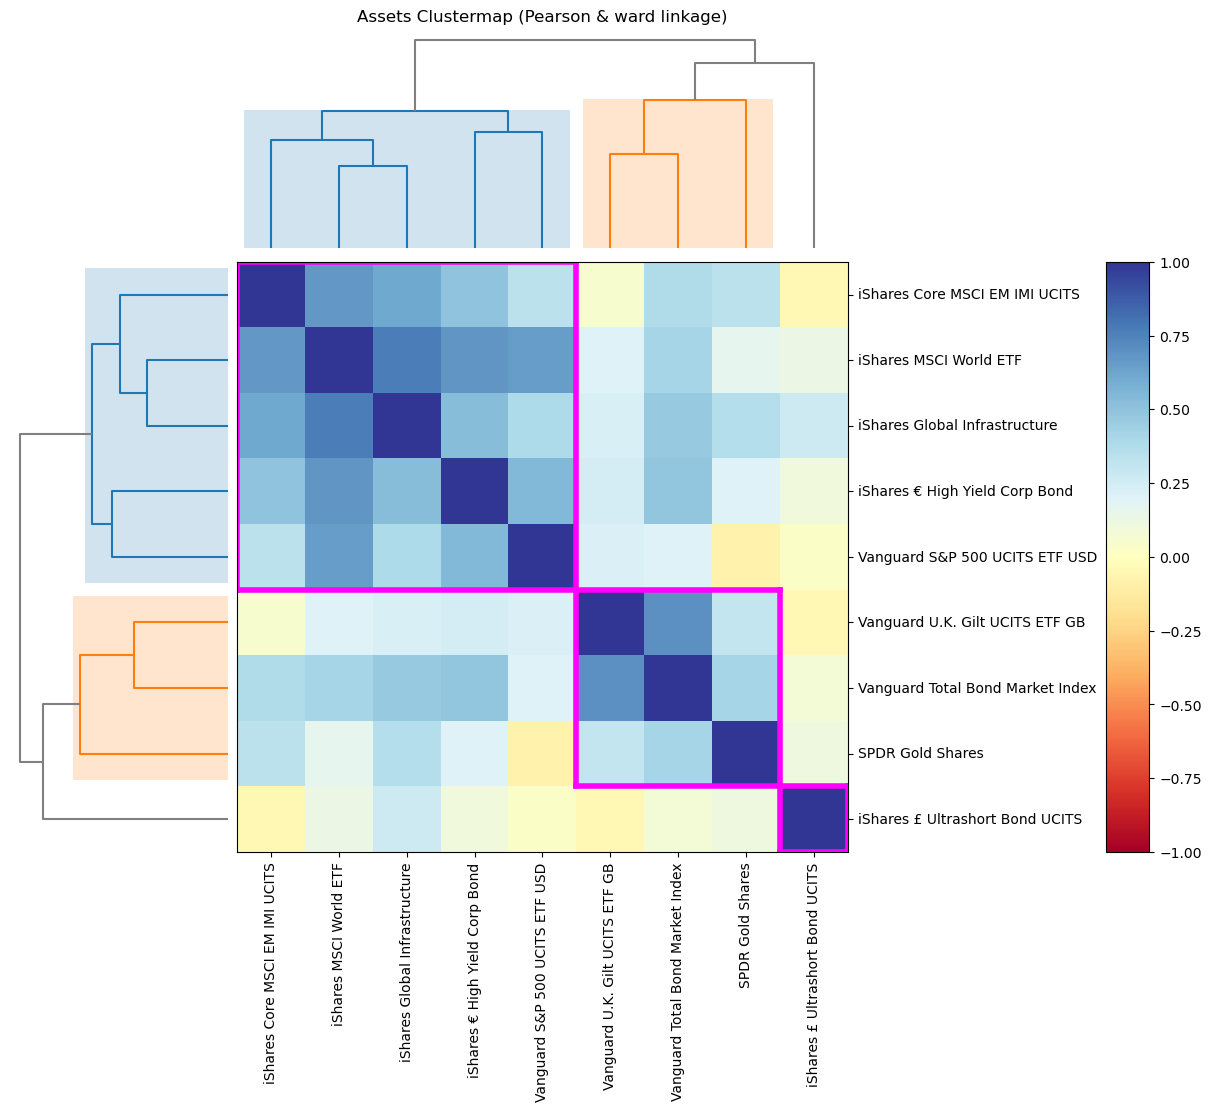

In [155]:
# Plotting assets clusters for Hirarchical Risk Parity (HRP) portfolio construction

ax_HRP_clustering= rp.plot_clusters(returns=arith_returns_scaled,
                      codependence='pearson',
                      linkage='ward',
                      k=None,
                      max_k=10,
                      leaf_order=True,
                      dendrogram=True,
                      #linecolor='tab:purple',
                      ax=None)